In [ ]:
import torch
from transformers import YolosFeatureExtractor, YolosForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [ ]:
from torchvision.ops import nms

In [ ]:
def image_classification(image_path, confidence_threshold=0.8, iou_threshold=0.5):
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt")

    outputs = model(**inputs)

    logits = outputs.logits
    bboxes = outputs.pred_boxes

    target_sizes = torch.tensor([image.size[::-1]])
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    print(results)

    scores = results["scores"]
    labels = results["labels"]
    boxes = results["boxes"]

    keep = scores > confidence_threshold
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]

    keep_indices = nms(boxes, scores, iou_threshold)
    boxes = boxes[keep_indices]
    scores = scores[keep_indices]
    labels = labels[keep_indices]

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for score, label, box in zip(scores, labels, boxes):
        box = [round(i, 2) for i in box.tolist()]
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
        ax.text(xmin, ymin - 10, label_text, color='red', fontsize=9, bbox=dict(facecolor='yellow', alpha=0.5))

    ax.axis('off')

{'scores': tensor([0.9274, 0.6954, 0.9987, 0.9884, 0.9278], grad_fn=<IndexBackward0>), 'labels': tensor([3, 3, 3, 3, 3]), 'boxes': tensor([[145.6358, 170.7282, 275.5547, 220.8181],
        [229.0051, 171.9738, 378.8703, 235.4834],
        [314.0179, 178.9949, 525.3863, 282.2046],
        [231.2543, 170.9208, 384.5270, 235.0391],
        [146.2546, 171.2660, 275.3754, 220.7629]], grad_fn=<IndexBackward0>)}


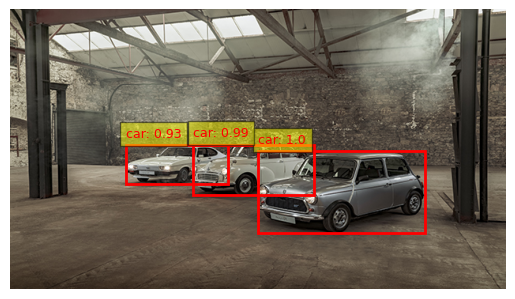

In [7]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Computer_vision/cars.jpg"

image_classification(image_path)